<a href="https://colab.research.google.com/github/mitsu666/Lecture2021/blob/main/Lecture06_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実習線形回帰モデル

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics import mean_squared_error

sns.set(style='darkgrid')

boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


# 1. 変数変換

## 1.1. ポイント① 文字列がないかどうか

In [ ]:
#変数チェック
df.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS       float64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD        float64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
target     float64
dtype: object

### 全てfloat(浮動小数点型）つまり数値変数

#1.2. 目的変数との線形関係確認

CRIM
ZN
INDUS
CHAS
NOX
RM
AGE
DIS
RAD
TAX
PTRATIO
B
LSTAT


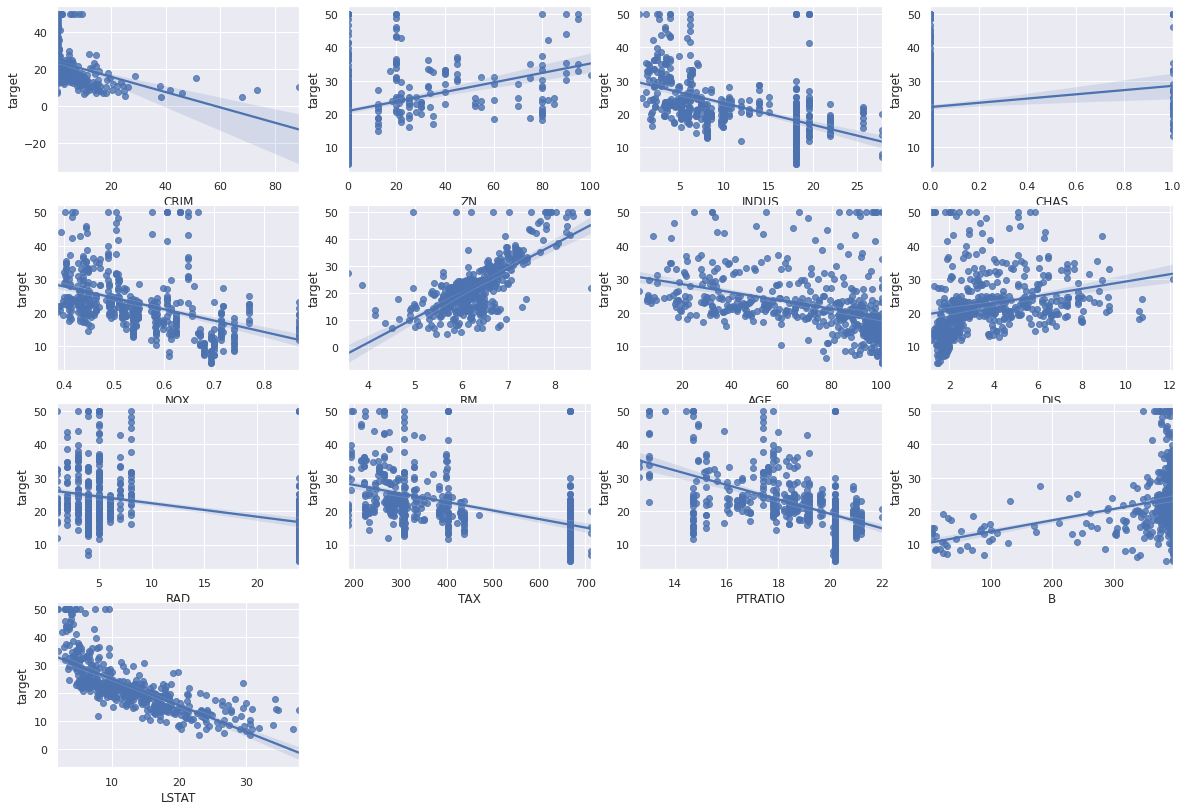

In [ ]:
plt.figure(figsize=(20,14))
for i,col in enumerate([col for col in df.columns if col.find('target')==-1]):
  print (col)
  plt.subplot(4,4,i+1)
  sns.regplot(data=df, x=col, y='target')
  #plt.scatter(df[col],df['target'])
  #plt.title(col)
  #plt.legend()

### 怪しいものあるが、大体線形関係にありそう

#2. 説明変数加工

## 2.1 欠損処理

In [ ]:
#欠損確認
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
target     0
dtype: int64

### 欠損なし

## 2.2. 訓練・検証用データ分割

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=12345)

print (df_train.shape)
print (df_test.shape)

(354, 14)
(152, 14)


## 2.3. 外れ値処理

CRIM
ZN
INDUS
CHAS
NOX
RM
AGE
DIS
RAD
TAX
PTRATIO
B
LSTAT


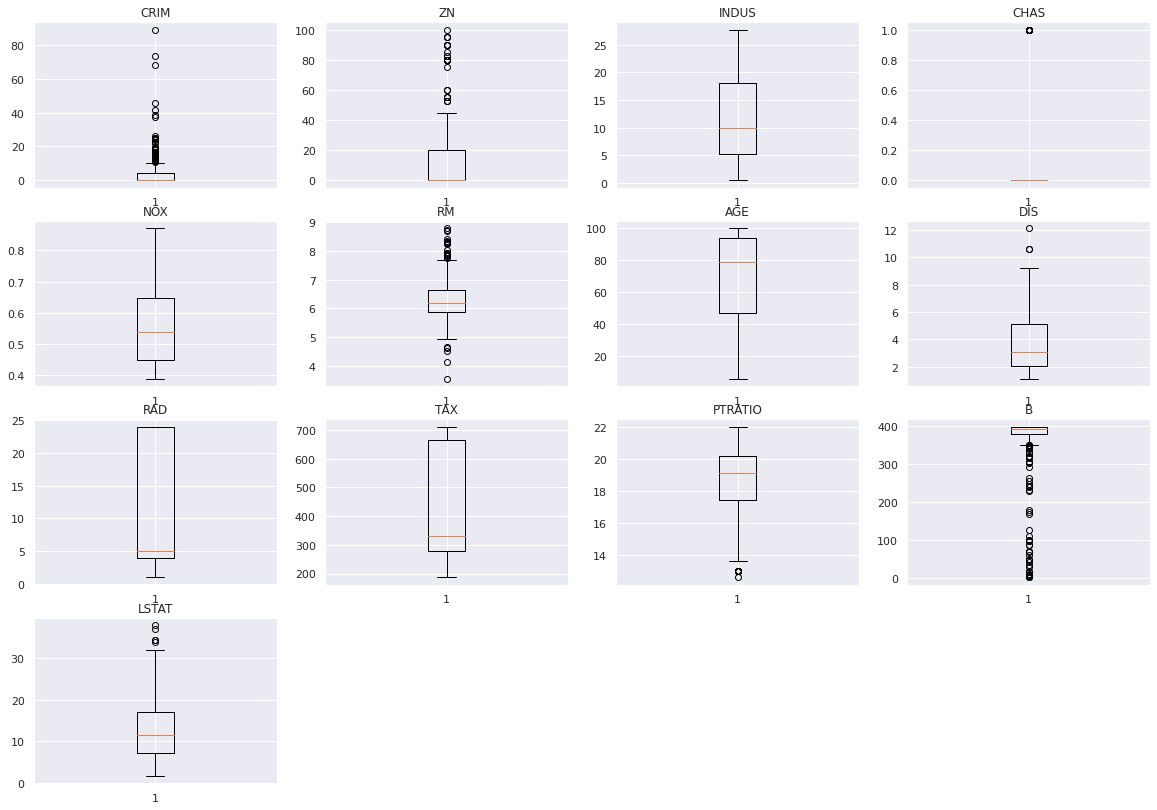

In [ ]:
plt.figure(figsize=(20,14))
for i,col in enumerate([col for col in df.columns if col.find('target')==-1]):
  print (col)
  plt.subplot(4,4,i+1)
  plt.boxplot(df_train[col])
  plt.title(col)

### CRIM ZN RM DIS B LSTAT を丸める（ここは上の図から目でみて決める）

In [ ]:
df_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,3.947146,10.894068,11.230932,0.076271,0.558417,6.308090,69.623729,3.739366,9.776836,408.491525,18.485593,358.925311,12.860141,22.586158
std,9.439048,22.094555,6.802385,0.265807,0.116870,0.710102,27.700004,2.089708,8.801457,171.159042,2.155076,89.132274,7.237538,9.515620
min,0.006320,0.000000,0.460000,0.000000,0.389000,3.561000,6.000000,1.129600,1.000000,187.000000,12.600000,2.520000,1.730000,5.000000
25%,0.084020,0.000000,5.190000,0.000000,0.450000,5.889500,47.200000,2.066825,4.000000,277.000000,17.400000,377.522500,7.182500,16.600000
50%,0.268880,0.000000,9.900000,0.000000,0.538000,6.205000,78.800000,3.095650,5.000000,330.000000,19.100000,391.985000,11.445000,21.150000
75%,4.251580,20.000000,18.100000,0.000000,0.647000,6.628000,94.100000,5.112625,24.000000,666.000000,20.200000,396.270000,17.205000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [ ]:
#外れ値処理関数
def roundout(col,pct,train_col):
  pct_low = np.percentile(train_col,pct)
  pct_high = np.percentile(train_col,100-pct)
  col[col<pct_low] = pct_low
  col[col>pct_high] = pct_high
  return (col)

In [ ]:
#99%タイルで丸める
for col in ['CRIM','ZN','RM','DIS','B','LSTAT']:
  roundout(df_train[col],100-95,df_train[col])
  roundout(df_test[col],100-95,df_train[col])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, valu

In [ ]:
df_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000,354.000000
mean,3.021894,10.403955,11.230932,0.076271,0.558417,6.308092,69.623729,3.691724,9.776836,408.491525,18.485593,361.833141,12.686938,22.586158
std,5.031502,20.402231,6.802385,0.265807,0.116870,0.597303,27.700004,1.942604,8.801457,171.159042,2.155076,78.620952,6.688585,9.515620
min,0.027518,0.000000,0.460000,0.000000,0.389000,5.398450,6.000000,1.449345,1.000000,187.000000,12.600000,93.769000,3.661500,5.000000
25%,0.084020,0.000000,5.190000,0.000000,0.450000,5.889500,47.200000,2.066825,4.000000,277.000000,17.400000,377.522500,7.182500,16.600000
50%,0.268880,0.000000,9.900000,0.000000,0.538000,6.205000,78.800000,3.095650,5.000000,330.000000,19.100000,391.985000,11.445000,21.150000
75%,4.251580,20.000000,18.100000,0.000000,0.647000,6.628000,94.100000,5.112625,24.000000,666.000000,20.200000,396.270000,17.205000,25.000000
max,17.181015,76.750000,27.740000,1.000000,0.871000,7.687750,100.000000,7.826500,24.000000,711.000000,22.000000,396.900000,26.685500,50.000000


In [ ]:
df_test.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
count,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000,152.000000
mean,2.481889,11.942352,10.917500,0.052632,0.546027,6.266084,66.132237,3.855819,9.019737,407.644737,18.385526,355.836712,11.988875,22.408553
std,4.387932,24.596586,7.011307,0.224035,0.113439,0.555121,29.113982,1.955985,8.488770,162.819626,2.193319,81.428641,6.298839,8.437475
min,0.027591,0.000000,0.740000,0.000000,0.385000,5.401407,2.900000,1.452826,1.000000,188.000000,12.600000,95.693650,3.686525,6.300000
25%,0.069095,0.000000,4.950000,0.000000,0.449000,5.868750,36.750000,2.116550,4.000000,286.250000,16.875000,368.487500,6.560000,17.675000
50%,0.218250,0.000000,8.350000,0.000000,0.528000,6.235000,71.450000,3.398100,5.000000,358.000000,18.650000,390.945000,11.300000,21.600000
75%,2.395598,0.000000,18.100000,0.000000,0.605000,6.599250,93.925000,5.218725,8.000000,518.250000,20.200000,395.982500,15.707500,25.500000
max,16.941025,75.612500,27.740000,1.000000,0.871000,7.686612,100.000000,7.826500,24.000000,711.000000,21.200000,396.900000,26.655925,50.000000


CRIM
ZN
INDUS
CHAS
NOX
RM
AGE
DIS
RAD
TAX
PTRATIO
B
LSTAT


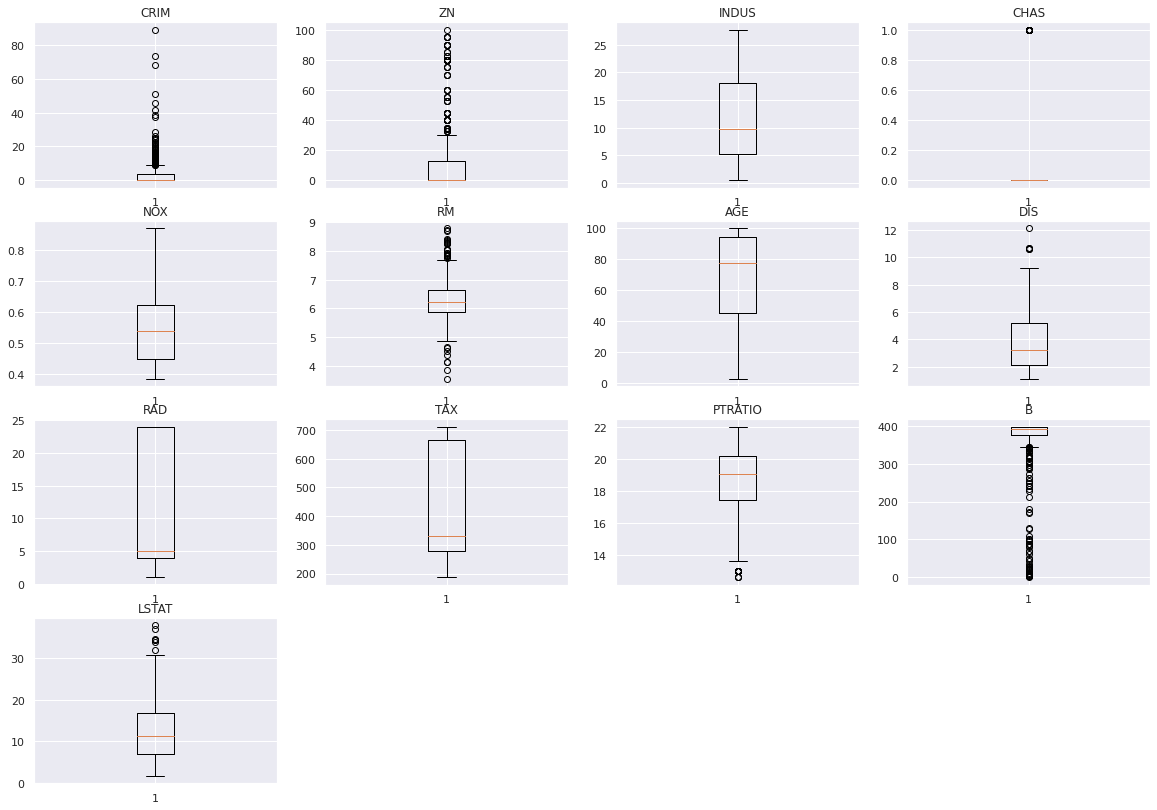

In [ ]:
plt.figure(figsize=(20,14))
for i,col in enumerate([col for col in df.columns if col.find('target')==-1]):
  print (col)
  plt.subplot(4,4,i+1)
  plt.boxplot(df[col])
  plt.title(col)

## 2.5 標準化

In [ ]:
#説明変数と目的変数を分離
X_train = df_train[[col for col in df_train.columns if col.find('target')==-1]]
y_train = df_train['target'] 

X_test = df_test[[col for col in df_test.columns if col.find('target')==-1]]
y_test = df_test['target'] 

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = pd.DataFrame(scaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_standard = pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X_test.columns)

Text(0.5, 1.0, 'after standarlize CRIM')

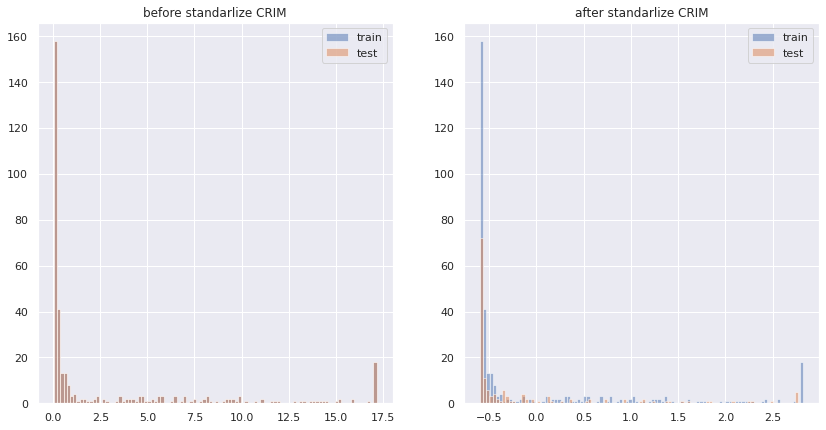

In [ ]:
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.hist(X_train['CRIM'],bins=100,label='train',alpha=0.5)
plt.hist(X_train['CRIM'],bins=100,label='test',alpha=0.5)
plt.legend()
plt.title('before standarlize CRIM')
plt.subplot(1,2,2)
plt.hist(X_train_standard['CRIM'],bins=100,label='train',alpha=0.5)
plt.hist(X_test_standard['CRIM'],bins=100,label='test',alpha=0.5)
plt.legend()
plt.title('after standarlize CRIM')

# 3. 変数選択・モデリング

## 3.1 変数選択

In [ ]:
print (pd.concat([X_train_standard,y_train],axis=1).corr().iloc[:,-1].to_frame())

           target
CRIM    -0.469945
ZN       0.396815
INDUS   -0.526323
CHAS     0.147588
NOX     -0.434594
RM       0.738446
AGE     -0.388494
DIS      0.282184
RAD     -0.381255
TAX     -0.474342
PTRATIO -0.534344
B        0.316289
LSTAT   -0.746091
target   1.000000


CRIM
ZN
INDUS
CHAS
NOX
RM
AGE
DIS
RAD
TAX
PTRATIO
B
LSTAT


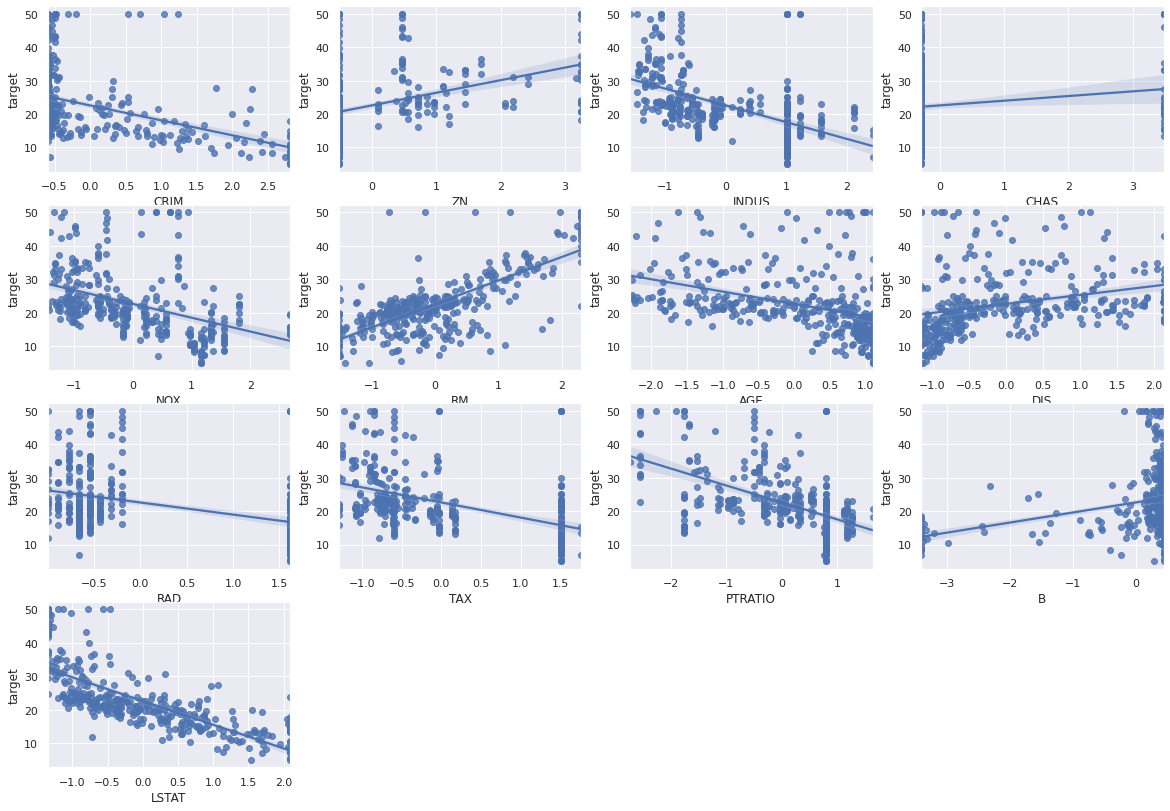

In [ ]:
plt.figure(figsize=(20,14))
for i,col in enumerate([col for col in df.columns if col.find('target')==-1]):
  print (col)
  plt.subplot(4,4,i+1)
  sns.regplot(data=pd.concat([X_train_standard,y_train],axis=1), x=col, y='target')
  #plt.scatter(df[col],df['target'])
  #plt.title(col)
  #plt.legend()

### 変数増加法での変数選択
Rには組み込みの関数が存在しているが、pythonにはないので関数を定義する

(参考)

https://www.programmersought.com/article/62501087018/

In [ ]:
def forward_select(data,target):
  variate=set(data.columns)    # Convert field names to dictionary types
  #variate.remove(target)    # Remove the field name of the dependent variable
  selected=[]
  current_score,best_new_score=float('inf'),float('inf')    #The current score and the best score initial value are infinite (becauseAICThe smaller the better) 
        # Filter variable
  #data = sm.add_constant(data, prepend=False)

  while variate:
    aic_with_variate=[]
    for candidate in variate:    ## traverse the arguments one by one
      #formula="{}~{}".format(target,"+".join(selected+[candidate]))    #Connect the argument names
      aic=sm.OLS(target,sm.add_constant(data[selected+[candidate]],prepend=False)).fit().aic #Using the ols training model to get the aic value
      aic_with_variate.append((aic,candidate))    # put the first aic value into the empty list
    aic_with_variate.sort(reverse=True)    #Descending order aic value
    best_new_score,best_candidate=aic_with_variate.pop()    # ic  is equal to the last value of the delete list, and the best argument is equal to the last argument of the list
    if current_score>best_new_score:    #If the current aic value is greater than the best aic value
      variate.remove(best_candidate)    # Remove the added variable name, that is, the second loop, do not consider this argument
      selected.append(best_candidate)    #Use this argument as an argument added to the model
      current_score=best_new_score #The latest score is equal to the best score
      print("aic is {},continuing!".format(current_score))    #output the smallest aic value
    else:
      print(current_score,best_new_score,best_candidate,selected)
      print("for selection over!")
      break
  formula="{}~{}".format(target,"+".join(selected))    # 
  print("final formula is {}".format(formula))
  model=sm.OLS(target,sm.add_constant(data[selected],prepend=False)).fit()
  return(model,selected)

In [ ]:
model, selected = forward_select(X_train_standard ,y_train)

aic is 2314.741887088294,continuing!
aic is 2202.166854347588,continuing!
aic is 2152.5080427406197,continuing!
aic is 2139.610712042585,continuing!
aic is 2131.752438267571,continuing!
aic is 2124.091789067412,continuing!
aic is 2107.743795232727,continuing!
2107.743795232727 2108.5153266838784 CRIM ['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'B', 'DIS', 'NOX']
for selection over!
final formula is 429     9.5
305    28.4
296    27.1
246    24.3
417    10.4
       ... 
420    16.7
129    14.3
285    22.0
485    21.2
482    25.0
Name: target, Length: 354, dtype: float64~LSTAT+RM+PTRATIO+CHAS+B+DIS+NOX


In [ ]:
#モデルサマリー
model.summary()

#選択された変数一覧
print (f'選択された変数 {selected}')

選択された変数 ['LSTAT', 'RM', 'PTRATIO', 'CHAS', 'B', 'DIS', 'NOX']


In [ ]:
#選択された変数と選択されなかった変数
varlist = pd.DataFrame(X_train_standard.columns,index=X_train_standard.columns,columns=['選択された変数']).isin(selected).astype(int)
print (varlist)

         選択された変数
CRIM           0
ZN             0
INDUS          0
CHAS           1
NOX            1
RM             1
AGE            0
DIS            1
RAD            0
TAX            0
PTRATIO        1
B              1
LSTAT          1


#4. 評価

### 4.2 当てはまり確認


### 4.3 評価 残差分析 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Predict')

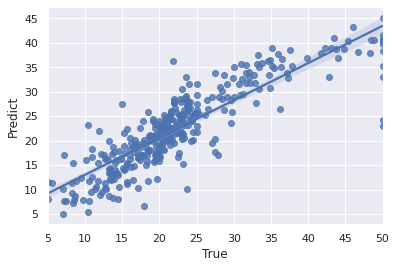

In [ ]:
sns.regplot(y_train,model.predict(sm.add_constant(X_train_standard[selected],prepend=False)))
plt.xlabel('True')
plt.ylabel('Predict')

Text(0, 0.5, 'The residual of the model')

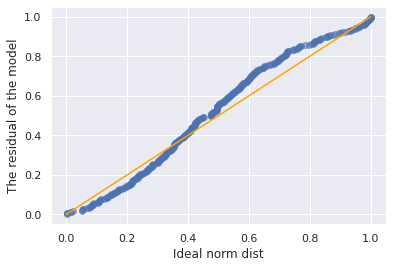

In [ ]:
#QQ-plot
predict = model.predict(sm.add_constant(X_train_standard[selected],prepend=False))
temp = (y_train-predict).sort_values()
temp = (temp - temp.mean()) / temp.std()
temp_ep = [(i+1)/ len(temp) for i in range(len(temp))]

plt.scatter(stats.norm.cdf(x=temp, loc=0, scale=1),temp_ep,alpha=0.5)
plt.plot(np.array([0,1]),np.array([0,1]),linestyle='solid',color='orange')
plt.xlabel('Ideal norm dist')
plt.ylabel('The residual of the model')


Text(0, 0.5, 'residual')

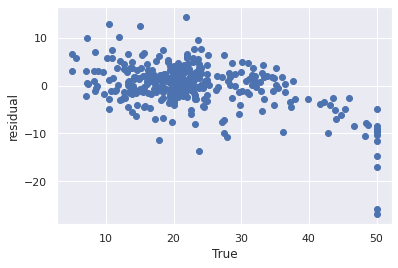

In [ ]:
#rezudual plot
plt.scatter(y_train,(model.predict(sm.add_constant(X_train_standard[selected],prepend=False))-y_train))
plt.xlabel('True')
plt.ylabel('residual')

### 4.4 RMSE

In [ ]:
#スコアリング
predict_train = model.predict(sm.add_constant(X_train_standard[selected],prepend=False))
predict_test = model.predict(sm.add_constant(X_test_standard[selected],prepend=False))
rmse_train = mean_squared_error(y_train,predict_train)
rmse_test = mean_squared_error(y_test,predict_test)

([<matplotlib.axis.XTick at 0x7f3d61255710>,
 <a list of 2 Text major ticklabel objects>)

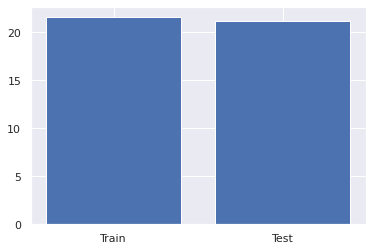

In [ ]:
plt.bar(['Train','Test'],[rmse_train,rmse_test])
plt.xticks([0,1])